In [1]:
import os
import pymongo
import analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from packaging.version import parse as parse_version
from typing import List, Tuple, Iterable, Any, Callable
from datetime import datetime
import numpy as np
import networkx as nx

from pymongo import MongoClient
MONGO_URL = "mongodb://localhost:27017/"
client = MongoClient(MONGO_URL, tz_aware=True)
package_db = client["license"]["package"]

In [2]:
def get_freq_table(counter: Counter, max: int = 9) -> pd.DataFrame:
    table = []
    other = {"Type": "Other", "Count": 0, "Percentage": 0}
    total = sum(counter.values())
    for key, value in sorted(counter.items(), key=lambda x: x[1], reverse=True):
        if len(table) < max:
            table.append(
                {
                    "Type": key,
                    "Count": value,
                    "Percentage": f"{100 * value / total:.2f}%",
                }
            )
        else:
            other["Count"] += value
    if other["Count"] != 0:
        other["Percentage"] = f"{100 * other['Count'] / total:.2f}%"
        table.append(other)
    return pd.DataFrame(table)

In [3]:
def plot_yearly_freq(
    ax: plt.Axes,
    series: Iterable[Tuple[datetime, Any]],
    percentage: bool = False,
    max: int = 9,
    order: Callable = lambda x: -x[1],
    palette: str = "Set2"
):
    yearly_counter = defaultdict(Counter)
    all_values = Counter()

    for date, value in series:
        yearly_counter[date.year][value] += 1
        all_values[value] += 1

    if len(all_values) > max:
        temp = Counter({k: v for k, v in all_values.most_common(max)})
        temp["Other"] = sum(all_values.values()) - sum(temp.values())
        all_values = temp
        for year, counter in yearly_counter.items():
            temp = Counter({k: counter[k] for k in all_values})
            temp["Other"] = sum(counter.values()) - sum(temp.values())
            yearly_counter[year] = temp

    if percentage:
        for year, counter in yearly_counter.items():
            yearly_counter[year] = Counter(
                {k: 100 * v / sum(counter.values()) for k, v in counter.items()}
            )

    years = sorted(yearly_counter.keys())
    counts = {}
    for k, _ in sorted(all_values.items(), key=order):
        counts[k] = [yearly_counter[year][k] for year in years]

    colors = sns.color_palette(palette, len(counts))
    bottom = np.zeros(len(years))
    i = 0
    for label, count in counts.items():
        ax.bar(years, count, width=0.8, label=label, bottom=bottom, color=colors[i])
        i += 1
        bottom += count

    if percentage:
        ax.set_ylim(0, 103)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
    ax.set_xlim(years[0] - 0.7, years[-1] + 0.7)
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="x", labelsize=12)
    ax.set_xticks(range(years[0], years[-1] + 1, 2))
    ax.legend(loc="upper left")


In [4]:
def graph_analysis(root,version,which_tree,indep):
    tree=package_db.find_one({"name":root,"version":version})[which_tree]
    G = nx.DiGraph()
    G.add_node(root) 
    for i in tree:
        name=i["name"]
        G.add_node(name)
    for i in tree:
        name=i["name"]
        for c in i["constraints"]:
            fro=c["from"]
            if fro == "":
                G.add_edge(root,name)
            else:
                G.add_edge(fro,name)
    
    return G.in_degree(indep),G.out_degree(indep),nx.shortest_path_length(G,root,indep)

In [5]:
def smaller(df,max):
    lst=[]
    for c in ["in_degree","out_degree","layer"]:

        dic={}
        for i in range(1,max+1):
            count=0
            for j in df[c]:
                if j<i:
                    count+=1
            dic["<"+str(i)] = str(round((count/len(df[c]))*100,1))+"%"
        lst.append(dic)
    return pd.DataFrame(lst,index=["in_degree","out_degree","layer"])

In [6]:
pkgs_top, incompats_top = analysis.get_license_data(has_dep_tree=True, sample=True, n_jobs=20)

pkgs_top = pkgs_top[pkgs_top.which_tree == "tree_created"].copy()
incompats_top = incompats_top[incompats_top.which_tree == "tree_created"].copy()
pkgs_incompat_top = pkgs_top[pkgs_top["compat"] == "Incompatible"].copy()

incompat_source = dict()
incompat_stat = dict()
for (pkg, ver), df in incompats_top.groupby(["package", "version"]):
    incompat_stat[(pkg, ver)] = Counter(df.is_direct)
    if len(incompat_stat[(pkg, ver)]) == 2:
        incompat_source[(pkg, ver)] = "Both"
    elif True in incompat_stat[(pkg, ver)]:
        incompat_source[(pkg, ver)] = "Direct"
    else:
        incompat_source[(pkg, ver)] = "Indirect"
pkgs_incompat_top["incompat_source"] = pkgs_incompat_top.apply(lambda x: incompat_source[(x["package"], x["version"])], axis=1)
pkgs_incompat_top["n_incompat_deps"] = pkgs_incompat_top.apply(lambda x: sum(incompat_stat[(x["package"], x["version"])].values()), axis=1)

pkgs_incompat_top.head()

100%|██████████| 1000/1000.0 [00:18<00:00, 53.55it/s]


,package,version,date,license,license_type,which_tree,n_deps,compat,incompat_source,n_incompat_deps
6476,amundsen-databuilder,1.5.0,2019-12-13 17:53:41.766000+00:00,Apache-2.0,Permissive,tree_created,29,Incompatible,Direct,1
6484,amundsen-databuilder,4.0.3,2020-11-03 15:35:38.046000+00:00,Apache-2.0,Permissive,tree_created,18,Incompatible,Direct,1
6490,amundsen-databuilder,6.4.1,2021-11-29 08:54:57.251000+00:00,Apache-2.0,Permissive,tree_created,42,Incompatible,Direct,1
6498,amundsen-databuilder,7.4.2,2022-10-03 19:49:37.051000+00:00,Apache-2.0,Permissive,tree_created,47,Incompatible,Direct,1
13640,ansible-lint,4.0.0,2018-12-18 16:27:47.887000+00:00,MIT,Permissive,tree_created,3,Incompatible,Direct,1


In [7]:

incompats_top["in_degree"], incompats_top["out_degree"], incompats_top["layer"] = zip(*incompats_top.apply(lambda x: graph_analysis(x["package"],x["version"],x["which_tree"],x["dep_name"]), axis=1))

incompats_top.to_csv("res/license_incompatibilities.csv", index=False)
incompats_top.head()
print(len(incompats_top))

265


In [8]:
smaller(incompats_top,6)

,<1,<2,<3,<4,<5,<6
in_degree,0.0%,95.8%,100.0%,100.0%,100.0%,100.0%
out_degree,60.8%,68.7%,81.9%,90.2%,97.4%,97.7%
layer,0.0%,74.0%,96.2%,100.0%,100.0%,100.0%


In [9]:

get_freq_table(Counter(incompats_top["layer"]), max=10)

,Type,Count,Percentage
0,1,196,73.96%
1,2,59,22.26%
2,3,10,3.77%


In [10]:

get_freq_table(Counter(incompats_top["out_degree"]), max=10)

,Type,Count,Percentage
0,0,161,60.75%
1,2,35,13.21%
2,3,22,8.30%
3,1,21,7.92%
4,4,19,7.17%
5,8,3,1.13%
6,6,2,0.75%
7,5,1,0.38%
8,7,1,0.38%


In [11]:
get_freq_table(Counter(incompats_top["in_degree"]), max=10)

,Type,Count,Percentage
0,1,254,95.85%
1,2,11,4.15%


In [12]:
incompats_top_in=incompats_top[incompats_top["is_direct"]==False]
get_freq_table(Counter(incompats_top_in["in_degree"]), max=2
               )

,Type,Count,Percentage
0,1,65,94.20%
1,2,4,5.80%


In [13]:
smaller(incompats_top_in,6)

,<1,<2,<3,<4,<5,<6
in_degree,0.0%,94.2%,100.0%,100.0%,100.0%,100.0%
out_degree,49.3%,62.3%,81.2%,95.7%,100.0%,100.0%
layer,0.0%,0.0%,85.5%,100.0%,100.0%,100.0%


In [14]:
get_freq_table(Counter(incompats_top_in["out_degree"]), max=10)

,Type,Count,Percentage
0,0,34,49.28%
1,2,13,18.84%
2,3,10,14.49%
3,1,9,13.04%
4,4,3,4.35%


In [15]:
get_freq_table(Counter(incompats_top_in["layer"]), max=10)

,Type,Count,Percentage
0,2,59,85.51%
1,3,10,14.49%


In [16]:
print(np.mean(incompats_top_in.out_degree))
print(np.median(incompats_top_in.out_degree))

1.1159420289855073
1.0


In [17]:
os.makedirs("res/incompat_reports", exist_ok=True)
client = pymongo.MongoClient(analysis.MONGO_URL, tz_aware=True)
for pkg, ver, which_tree in set(zip(incompats_top.package, incompats_top.version, incompats_top.which_tree)):
    report = analysis.get_incompatibility_report(client, pkg, ver, which_tree)
    with open(f"res/incompat_reports/{pkg}_{ver}_{which_tree}.txt", "w") as f:
        f.write(report)
client.close()

In [18]:
get_freq_table(Counter(pkgs_top.compat))

,Type,Count,Percentage
0,Compatible,5731,55.74%
1,Unknown,4349,42.30%
2,Incompatible,202,1.96%


In [19]:
print(len(set(pkgs_top.package)))

3068


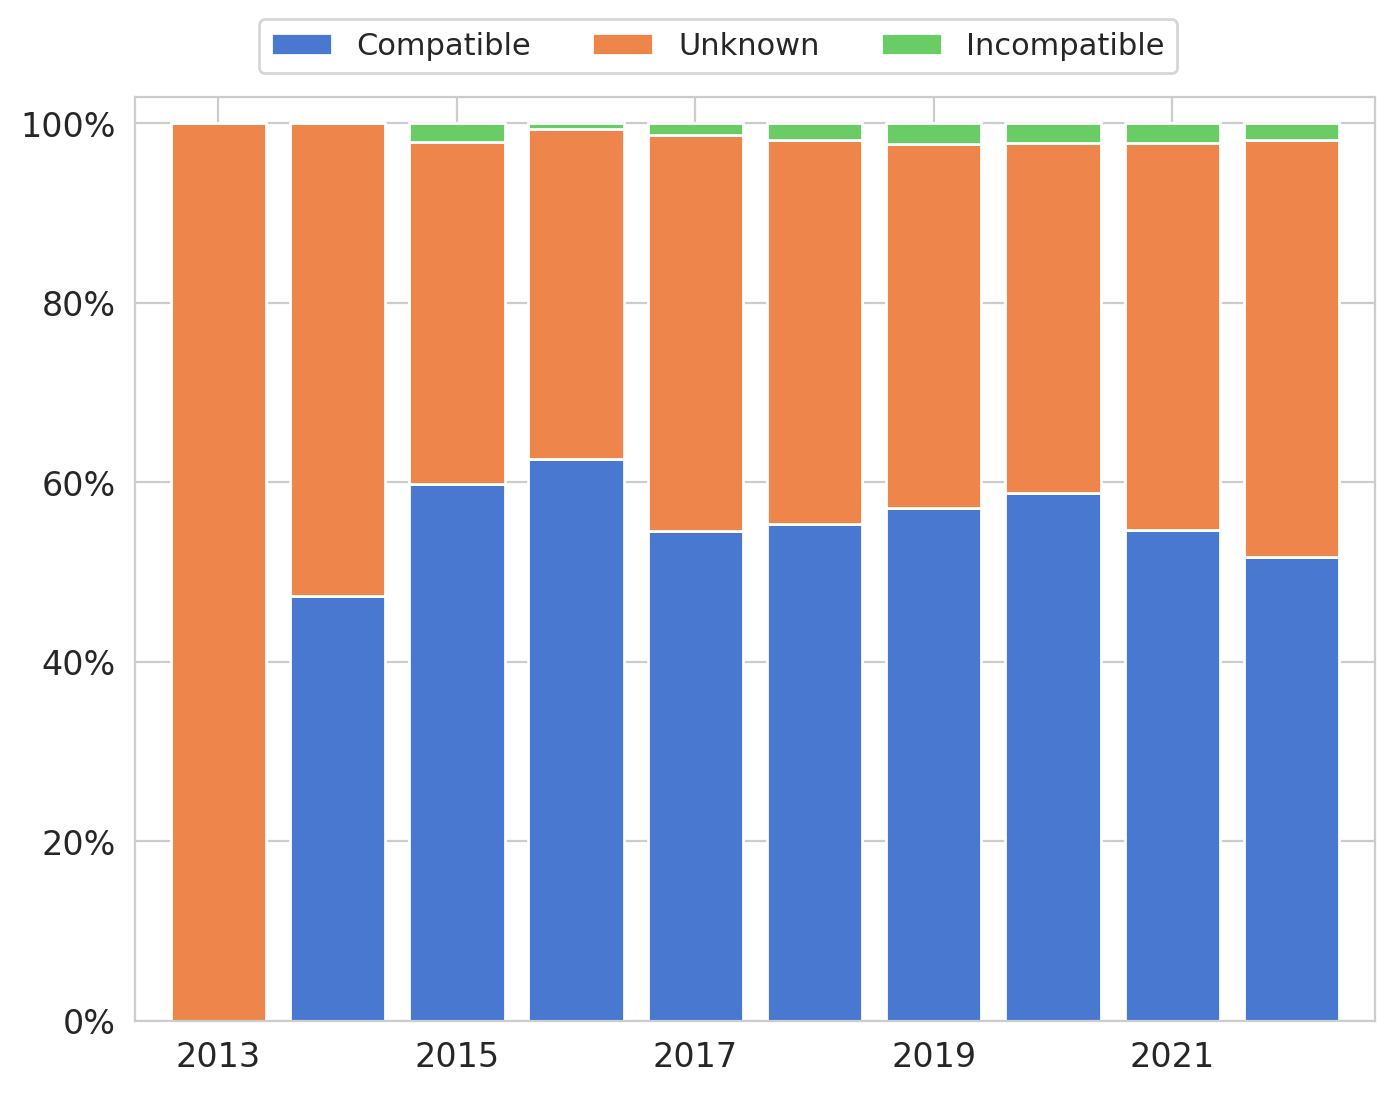

In [20]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(pkgs_top.date, pkgs_top.compat), percentage=True, palette="muted")
    # fig.autofmt_xdate()
    ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.47, 1.1), fontsize=11)
    fig.savefig("fig/incomp_percentage.pdf", bbox_inches='tight')

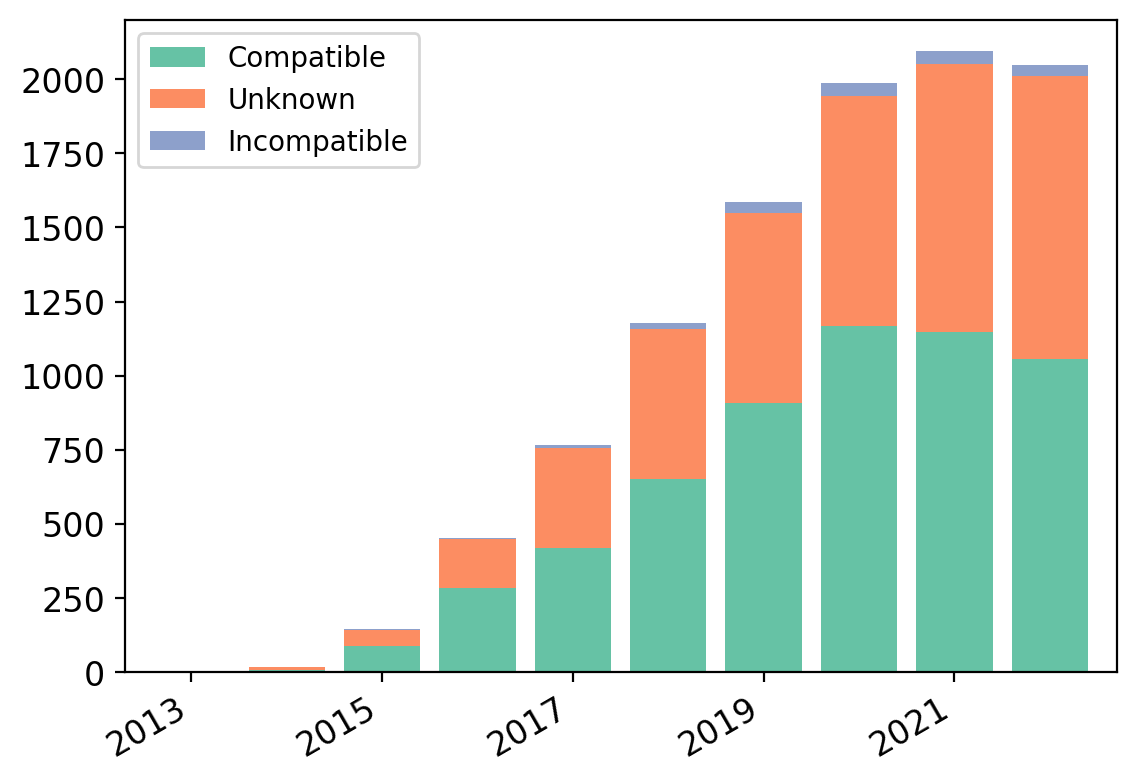

In [21]:
fig, ax = plt.subplots()
plot_yearly_freq(ax, zip(pkgs_top.date, pkgs_top.compat))
fig.autofmt_xdate()

In [22]:
get_freq_table(Counter(pkgs_incompat_top.incompat_source))

,Type,Count,Percentage
0,Direct,151,74.75%
1,Indirect,30,14.85%
2,Both,21,10.40%


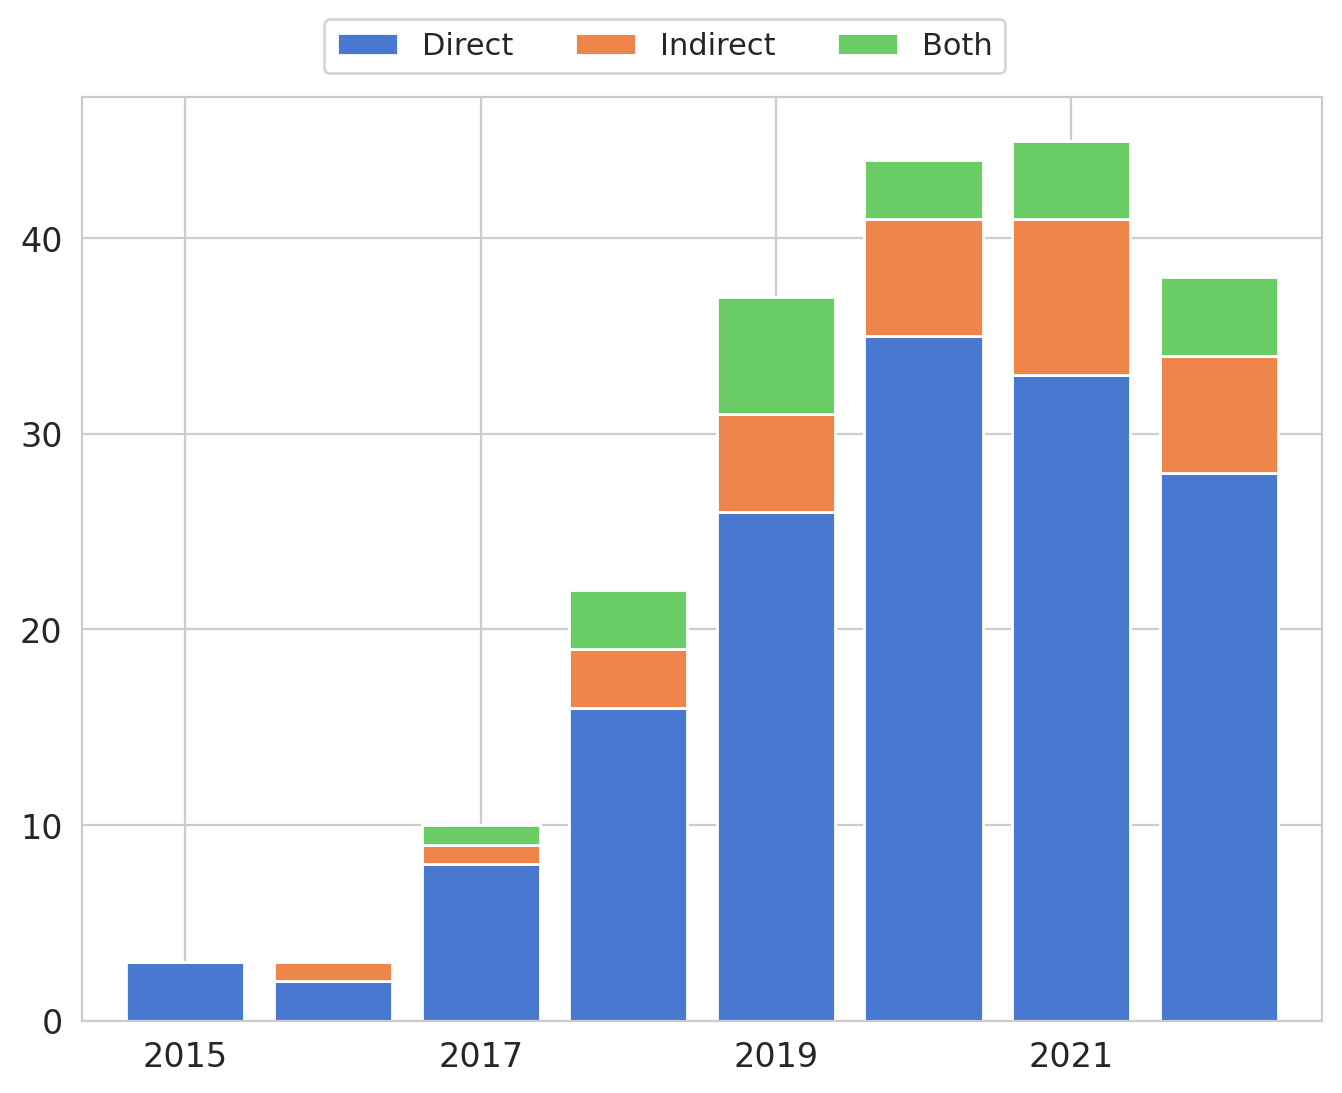

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(pkgs_incompat_top.date, pkgs_incompat_top.incompat_source), percentage=False, palette="muted")
    # fig.autofmt_xdate()
    ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.47, 1.1), fontsize=11)
    fig.savefig("fig/incompat_source.pdf", bbox_inches='tight')

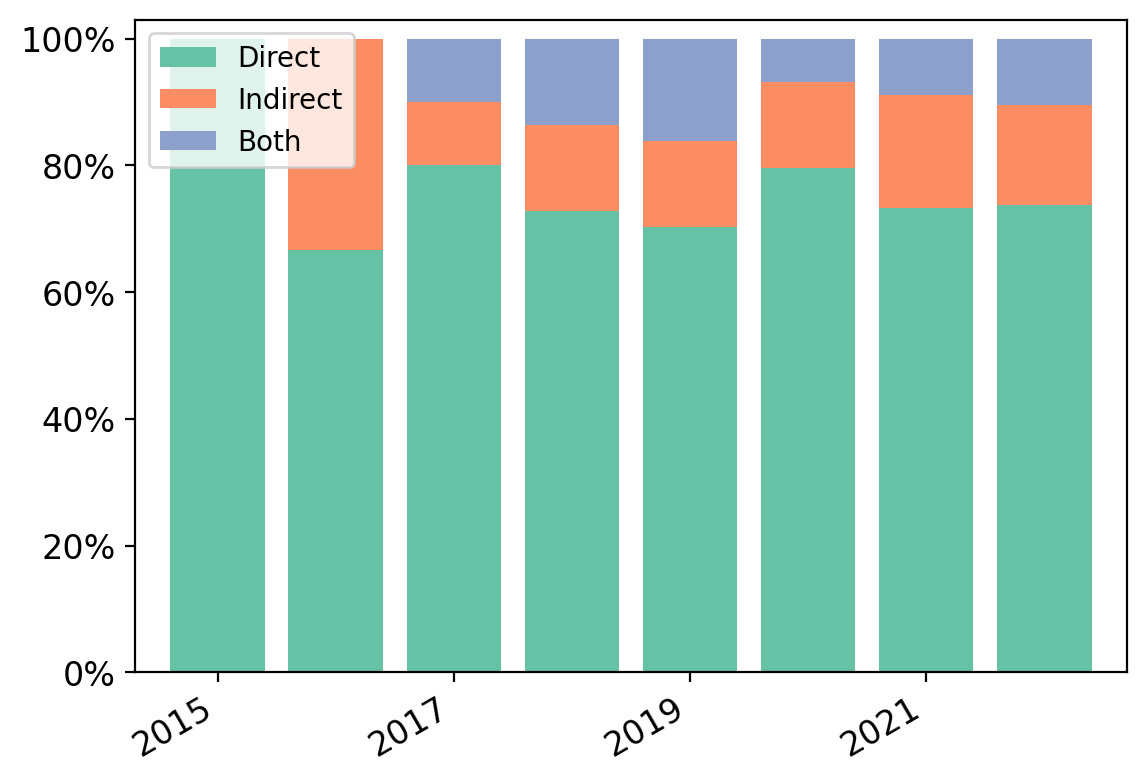

In [24]:
fig, ax = plt.subplots()
plot_yearly_freq(ax, zip(pkgs_incompat_top.date, pkgs_incompat_top.incompat_source), percentage=True)
fig.autofmt_xdate()

In [25]:
get_freq_table(Counter(zip(incompats_top.license, incompats_top.dep_license)), max=12)

,Type,Count,Percentage
0,"(Apache-2.0, GPL-3.0-only)",50,18.87%
1,"(MIT, GPL-3.0-only)",47,17.74%
2,"(MIT, GPL-2.0-only)",27,10.19%
3,"(BSD-3-Clause, GPL-3.0-only)",19,7.17%
4,"(Apache-2.0, GPL-2.0-only)",17,6.42%
5,"(MIT, GPL-3.0-or-later)",9,3.40%
6,"(MIT, EPL-1.0)",9,3.40%
7,"(GPL-2.0-only, Apache-2.0)",8,3.02%
8,"(GPL-2.0-only, LGPL-3.0-only)",8,3.02%
9,"(LGPL-2.1-only, Apache-2.0)",8,3.02%


In [26]:
get_freq_table(Counter(incompats_top.dep_name), max=12)

,Type,Count,Percentage
0,pylint,23,8.68%
1,unidecode,20,7.55%
2,fuzzywuzzy,12,4.53%
3,paho-mqtt,11,4.15%
4,requests,10,3.77%
5,ecos,10,3.77%
6,cursor,9,3.40%
7,yamllint,8,3.02%
8,chardet,7,2.64%
9,grandalf,7,2.64%


In [27]:
get_freq_table(Counter(pkgs_incompat_top.n_incompat_deps))

,Type,Count,Percentage
0,1,150,74.26%
1,2,44,21.78%
2,3,6,2.97%
3,4,1,0.50%
4,5,1,0.50%


Entire PyPI:


In [28]:
pkgs_all, incompats_all = analysis.get_license_data(has_dep_tree=True, sample=False, n_jobs=70)

pkgs_all = pkgs_all[pkgs_all.which_tree == "tree_created"].copy()
incompats_all = incompats_all[incompats_all.which_tree == "tree_created"].copy()
pkgs_incompat_all = pkgs_all[pkgs_all["compat"] == "Incompatible"].copy()

incompat_source = dict()
incompat_stat = dict()
for (pkg, ver), df in incompats_all.groupby(["package", "version"]):
    incompat_stat[(pkg, ver)] = Counter(df.is_direct)
    if len(incompat_stat[(pkg, ver)]) == 2:
        incompat_source[(pkg, ver)] = "Both"
    elif True in incompat_stat[(pkg, ver)]:
        incompat_source[(pkg, ver)] = "Direct"
    else:
        incompat_source[(pkg, ver)] = "Indirect"
pkgs_incompat_all["incompat_source"] = pkgs_incompat_all.apply(lambda x: incompat_source[(x["package"], x["version"])], axis=1)
pkgs_incompat_all["n_incompat_deps"] = pkgs_incompat_all.apply(lambda x: sum(incompat_stat[(x["package"], x["version"])].values()), axis=1)

pkgs_incompat_all.head()

87794it [03:33, 410.52it/s]                             


,package,version,date,license,license_type,which_tree,n_deps,compat,incompat_source,n_incompat_deps
543566,0x20bf,0.0.1,2022-03-08 23:49:14.391000+00:00,Apache-2.0,Permissive,tree_created,10,Incompatible,Direct,1
543454,1zlab-homepage,0.0.2,2020-10-06 14:50:06.141000+00:00,MIT,Permissive,tree_created,15,Incompatible,Direct,1
543456,1zlab-homepage,0.0.3,2021-02-22 11:36:18.132000+00:00,MIT,Permissive,tree_created,15,Incompatible,Direct,1
543444,2048,0.2,2017-11-19 08:04:38.100000+00:00,AGPL-3.0-only,Strong Copyleft,tree_created,2,Incompatible,Direct,1
543434,21cmmc,1.0.0.dev3,2020-09-24 16:26:31.219000+00:00,MIT,Permissive,tree_created,16,Incompatible,Direct,1


In [29]:
incompats_all["in_degree"], incompats_all["out_degree"], incompats_all["layer"] = zip(*incompats_all.apply(lambda x: graph_analysis(x["package"],x["version"],x["which_tree"],x["dep_name"]), axis=1))

incompats_all.to_csv("res/license_incompatibilities_PyPI.csv", index=False)
incompats_all.head()

,package,version,date,license,which_tree,dep_name,dep_version,dep_license,is_direct,in_degree,out_degree,layer
97607,0x20bf,0.0.1,2022-03-08 23:49:14.391000+00:00,Apache-2.0,tree_created,gnupg,2.3.1,GPL-3.0-or-later,True,1,0,1
97603,1zlab-homepage,0.0.2,2020-10-06 14:50:06.141000+00:00,MIT,tree_created,mysqlclient,2.0.1,GPL-3.0-only,True,1,0,1
97605,1zlab-homepage,0.0.3,2021-02-22 11:36:18.132000+00:00,MIT,tree_created,mysqlclient,2.0.3,GPL-3.0-only,True,1,0,1
97601,2048,0.2,2017-11-19 08:04:38.100000+00:00,AGPL-3.0-only,tree_created,pygame,1.9.3,LGPL-3.0-only,True,1,0,1
97599,21cmmc,1.0.0.dev3,2020-09-24 16:26:31.219000+00:00,MIT,tree_created,pymultinest,2.10,GPL-3.0-only,True,1,0,1


/tmp/ipykernel_4131058/2689194944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incompats_top_in["Scope"]  = incompats_top_in.apply(lambda x: "TOP", axis=1)


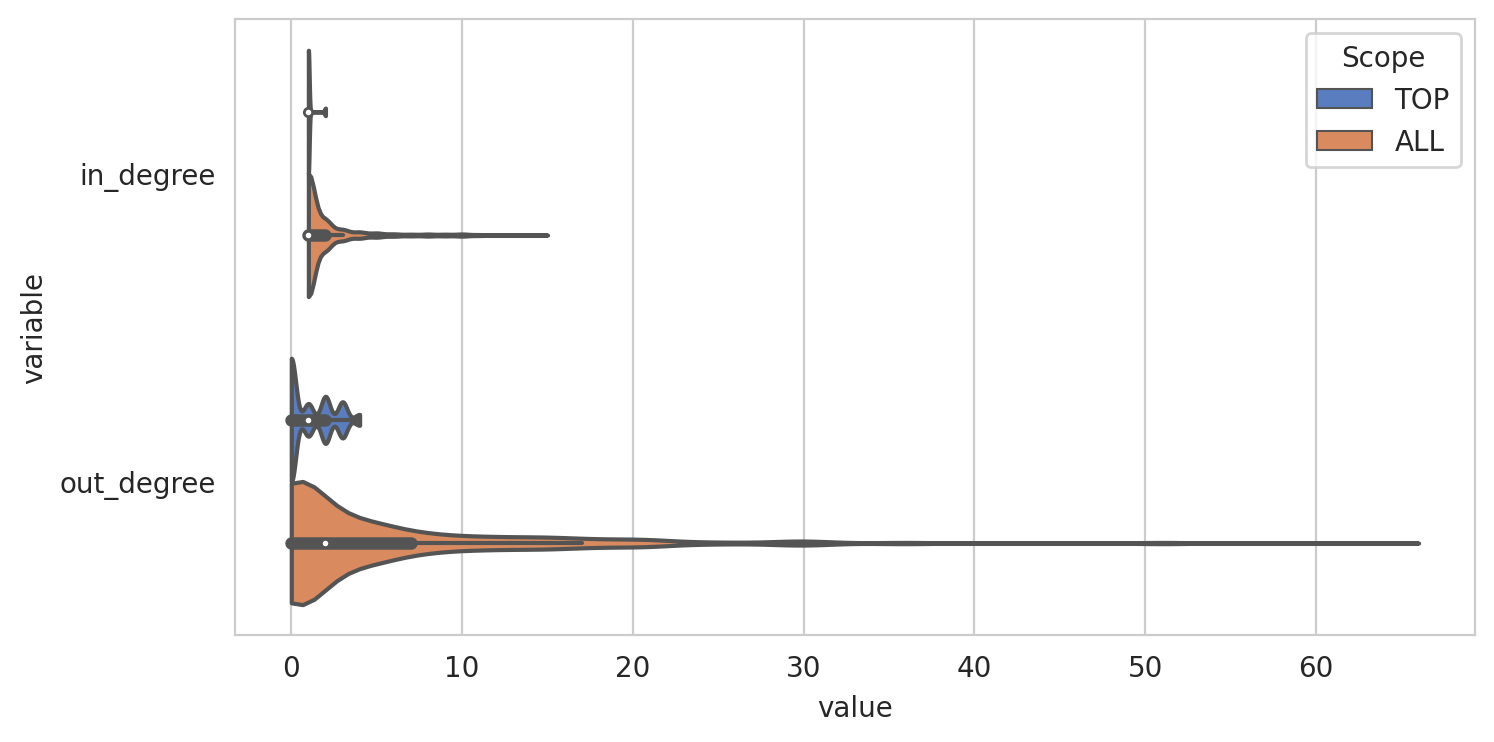

In [30]:


incompats_all_in=incompats_all[incompats_all["is_direct"]==False].copy()
incompats_all_in["Scope"]  = incompats_all_in.apply(lambda x: "ALL", axis=1)
incompats_top_in["Scope"]  = incompats_top_in.apply(lambda x: "TOP", axis=1)

incompats_mixed = pd.concat([incompats_top_in, incompats_all_in], ignore_index=True)
incompats_mixed = incompats_mixed[['Scope', 'in_degree', 'out_degree']]
incompats_mixed = incompats_mixed.melt(id_vars=["Scope"])
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.violinplot(data=incompats_mixed,y="variable",x="value",ax=ax,orient="h",hue="Scope",palette = 'muted',scale='width',cut=0,bw=0.2,showfliers=False)
    #ax.set_xlim(0,20)
    # fig.autofmt_xdate()
    # ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.47, 1.1), fontsize=11)
    fig.savefig("fig/incomp_analysis_pypi.pdf", bbox_inches='tight')




In [31]:
get_freq_table(Counter(incompats_all_in.layer),max=2)

,Type,Count,Percentage
0,2,15316,54.01%
1,3,8001,28.22%
2,Other,5039,17.77%


In [32]:
smaller(incompats_all_in,6)

,<1,<2,<3,<4,<5,<6
in_degree,0.0%,67.0%,82.8%,88.6%,91.9%,94.1%
out_degree,37.8%,49.8%,56.0%,61.2%,65.7%,72.4%
layer,0.0%,0.0%,54.0%,82.3%,92.1%,96.1%


In [33]:
smaller(incompats_all,6)

,<1,<2,<3,<4,<5,<6
in_degree,0.0%,75.4%,87.7%,91.9%,94.2%,95.8%
out_degree,45.6%,57.9%,63.7%,68.6%,74.1%,79.0%
layer,0.0%,38.7%,71.8%,89.1%,95.2%,97.6%


In [34]:
get_freq_table(Counter(incompats_all.layer),max=10)

,Type,Count,Percentage
0,1,17888,38.69%
1,2,15316,33.12%
2,3,8001,17.30%
3,4,2798,6.05%
4,5,1133,2.45%
5,6,768,1.66%
6,7,237,0.51%
7,8,91,0.20%
8,9,5,0.01%


In [35]:
get_freq_table(Counter(incompats_all.out_degree),max=10)

,Type,Count,Percentage
0,0,21092,45.62%
1,1,5687,12.30%
2,2,2684,5.80%
3,4,2562,5.54%
4,3,2257,4.88%
5,5,2229,4.82%
6,6,1059,2.29%
7,8,972,2.10%
8,11,848,1.83%
9,7,840,1.82%


In [36]:
get_freq_table(Counter(incompats_all.in_degree),max=10)

,Type,Count,Percentage
0,1,34864,75.40%
1,2,5692,12.31%
2,3,1941,4.20%
3,4,1067,2.31%
4,5,715,1.55%
5,6,425,0.92%
6,10,377,0.82%
7,8,362,0.78%
8,9,290,0.63%
9,7,278,0.60%


In [37]:
get_freq_table(Counter(incompats_all_in.in_degree),max=7)

,Type,Count,Percentage
0,1,19009,67.04%
1,2,4462,15.74%
2,3,1643,5.79%
3,4,934,3.29%
4,5,629,2.22%
5,6,356,1.26%
6,10,328,1.16%
7,Other,995,3.51%


In [38]:
get_freq_table(Counter(incompats_all_in.out_degree),max=10)

,Type,Count,Percentage
0,0,10729,37.84%
1,1,3397,11.98%
2,5,1891,6.67%
3,2,1758,6.20%
4,3,1474,5.20%
5,4,1280,4.51%
6,11,789,2.78%
7,6,692,2.44%
8,8,669,2.36%
9,9,629,2.22%


In [39]:
get_freq_table(Counter(incompats_all_in.layer),max=6)

,Type,Count,Percentage
0,2,15316,54.01%
1,3,8001,28.22%
2,4,2798,9.87%
3,5,1133,4.00%
4,6,768,2.71%
5,7,237,0.84%
6,Other,103,0.36%


In [40]:
get_freq_table(Counter(pkgs_all.compat))

,Type,Count,Percentage
0,Unknown,137904,50.74%
1,Compatible,114135,41.99%
2,Incompatible,19772,7.27%


In [41]:
print(np.mean(incompats_all_in.out_degree))
print(np.median(incompats_all_in.out_degree))

5.089928057553957
2.0


In [42]:
print(len(set(pkgs_all.package)))
print(len(incompats_all))

176955
46237


In [43]:
get_freq_table(Counter(zip(incompats_all.license, incompats_all.dep_license)), max=12)

,Type,Count,Percentage
0,"(GPL-2.0-only, GPL-3.0-only)",6683,14.45%
1,"(GPL-3.0-only, GPL-2.0-only)",6276,13.57%
2,"(MIT, GPL-3.0-only)",5154,11.15%
3,"(AGPL-3.0-only, LGPL-3.0-only)",4741,10.25%
4,"(GPL-2.0-only, Apache-2.0)",3416,7.39%
5,"(MIT, GPL-2.0-only)",2130,4.61%
6,"(GPL-2.0-only, LGPL-3.0-only)",1549,3.35%
7,"(Apache-2.0, GPL-3.0-only)",1326,2.87%
8,"(BSD-3-Clause, GPL-3.0-only)",1196,2.59%
9,"(MIT, GPL-3.0-or-later)",1014,2.19%


In [44]:
get_freq_table(Counter(incompats_all.dep_name), max=12)

,Type,Count,Percentage
0,chardet,2087,4.51%
1,unidecode,1318,2.85%
2,requests,1038,2.24%
3,paho-mqtt,726,1.57%
4,html2text,673,1.46%
5,pylint,664,1.44%
6,pycountry,656,1.42%
7,fuzzywuzzy,448,0.97%
8,pyqt5,383,0.83%
9,mysql-connector-python,381,0.82%


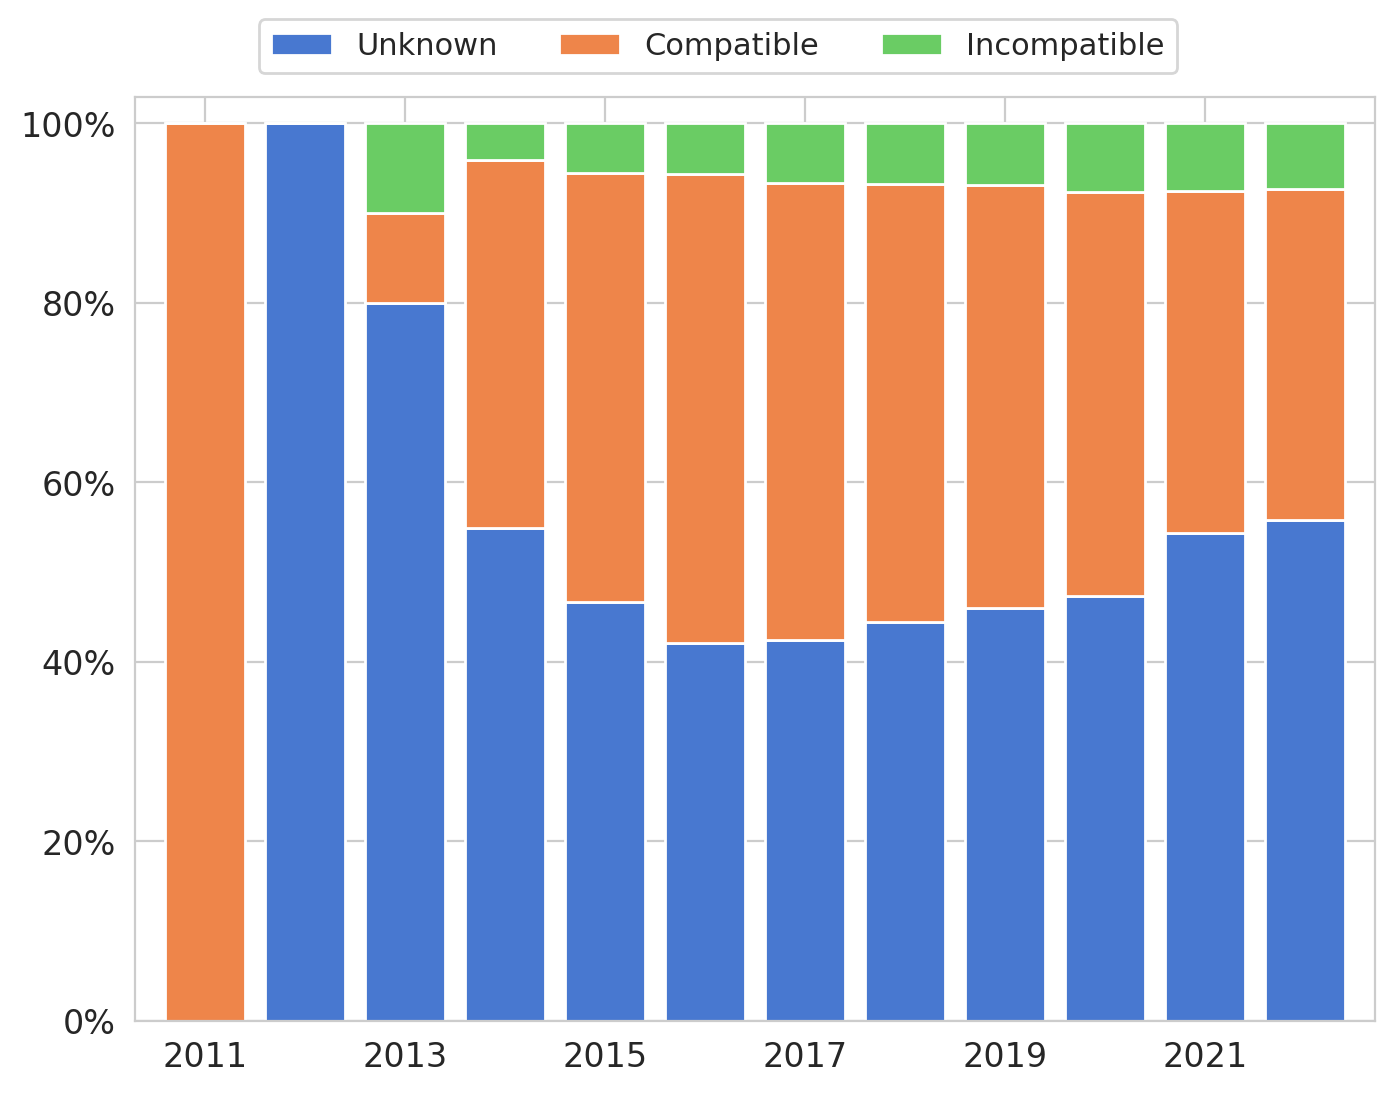

In [45]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(pkgs_all.date, pkgs_all.compat), percentage=True, palette="muted")
    # fig.autofmt_xdate()
    ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.47, 1.1), fontsize=11)
    fig.savefig("fig/incomp_percentage_pypi.pdf", bbox_inches='tight')

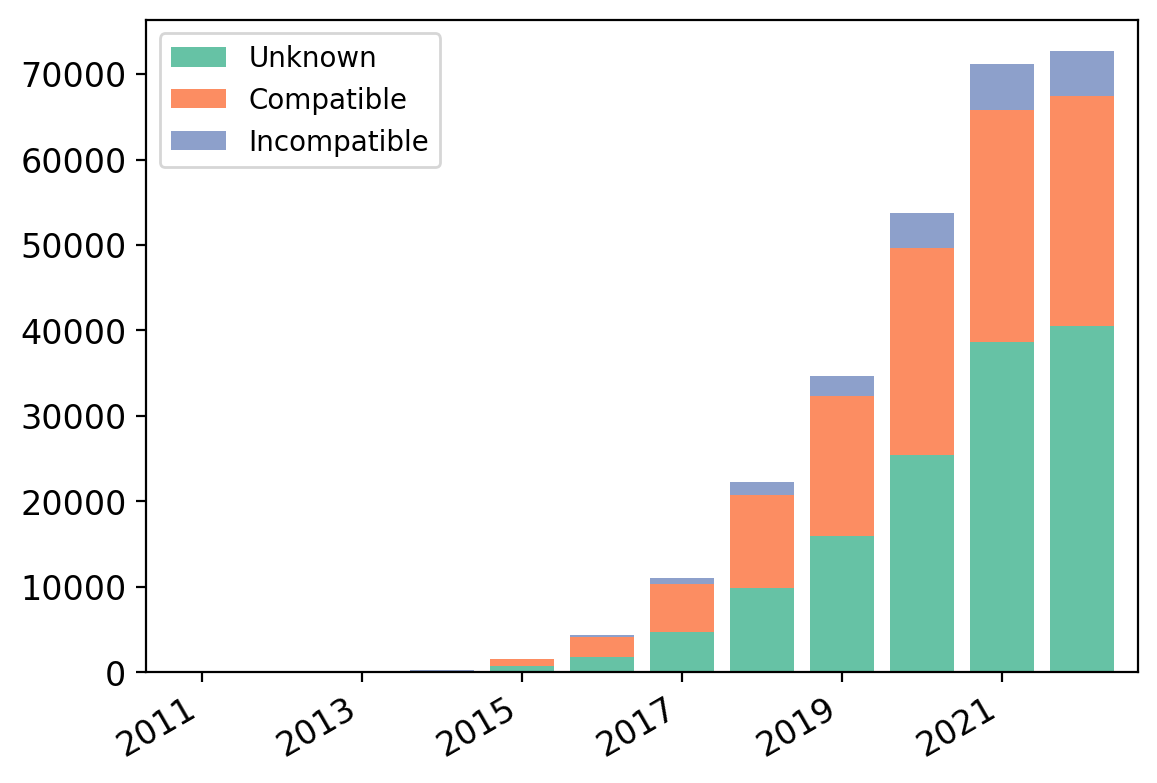

In [46]:
fig, ax = plt.subplots()
plot_yearly_freq(ax, zip(pkgs_all.date, pkgs_all.compat), percentage=False)
fig.autofmt_xdate()


In [47]:
get_freq_table(Counter(pkgs_incompat_all.incompat_source))

,Type,Count,Percentage
0,Direct,11620,58.77%
1,Indirect,5547,28.05%
2,Both,2605,13.18%


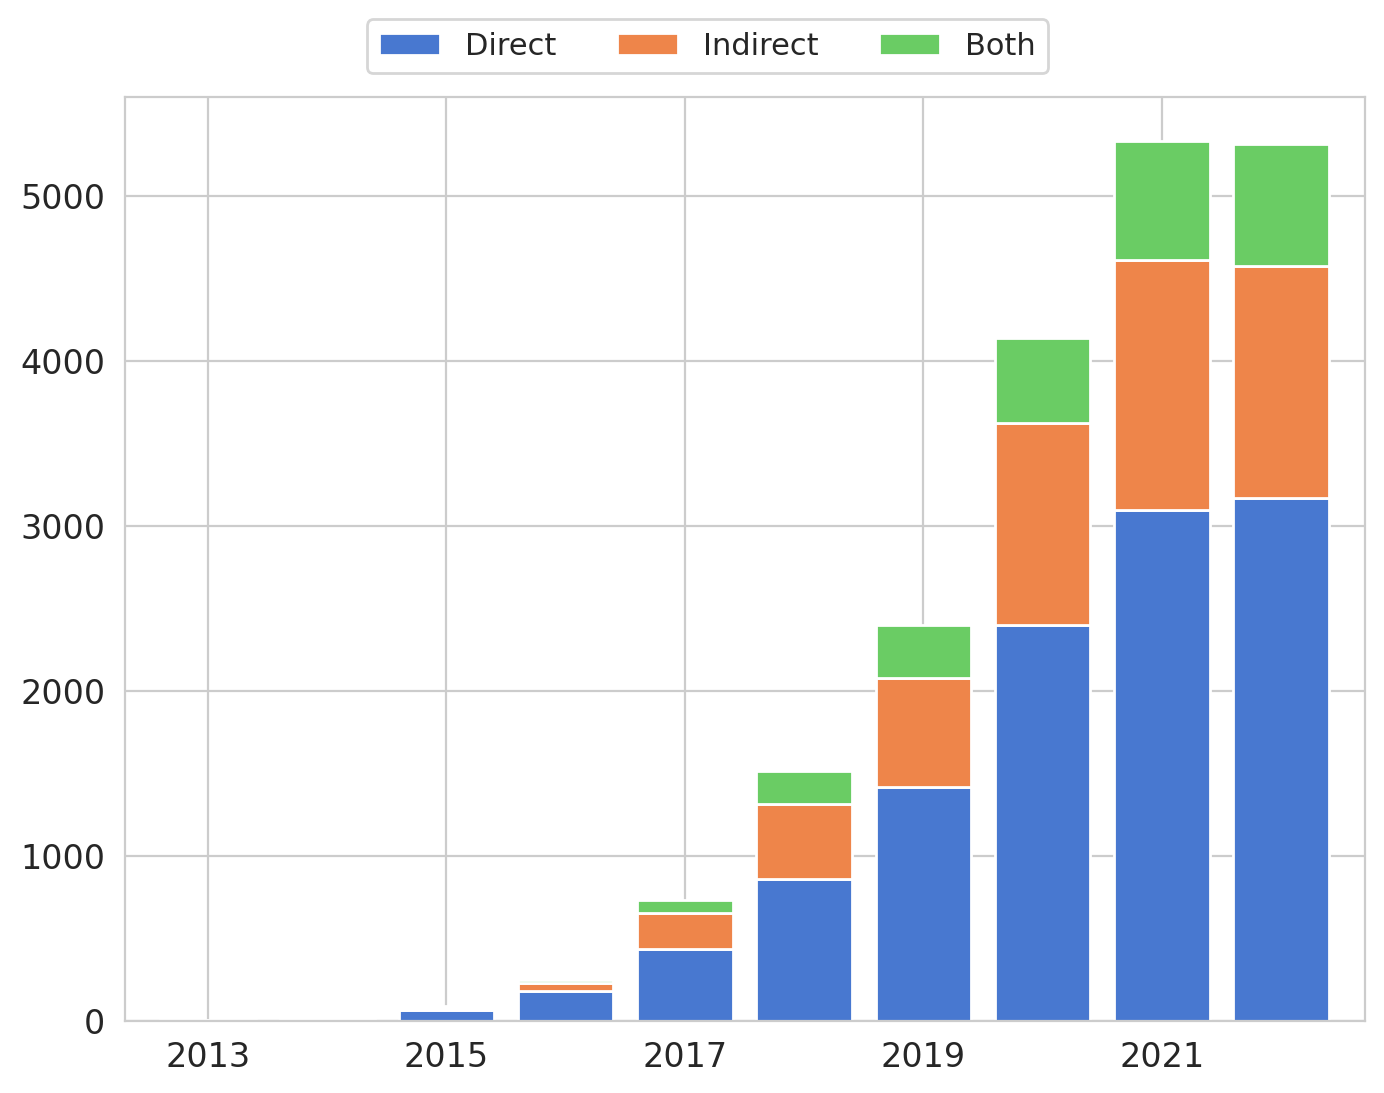

In [48]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(pkgs_incompat_all.date, pkgs_incompat_all.incompat_source), percentage=False, palette="muted")
    # fig.autofmt_xdate()
    ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.47, 1.1), fontsize=11)
    fig.savefig("fig/incompat_source_pypi.pdf", bbox_inches='tight')

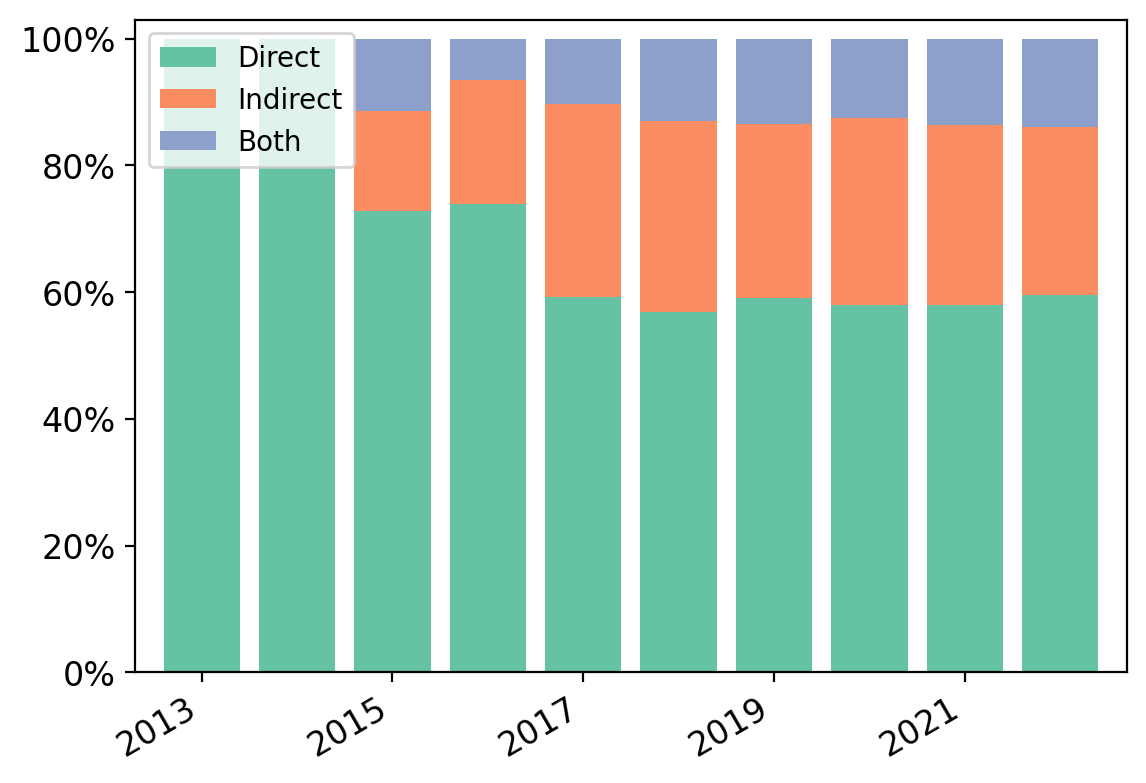

In [49]:
fig, ax = plt.subplots()
plot_yearly_freq(ax, zip(pkgs_incompat_all.date, pkgs_incompat_all.incompat_source), percentage=True)
fig.autofmt_xdate()